In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns     # you can install this with "pip install seaborn"
import sys
import pprint, math
from process_logs import *  # various functions used to process experiment log file
%matplotlib inline  
#print(plt.rcParams.keys())
params = {'font.size': 18, 'figure.titlesize':'medium','legend.fontsize': 'medium','legend.handlelength':1,
          'lines.linewidth':2, 'lines.markersize':12, 'legend.handletextpad':0,'axes.formatter.useoffset':False,}
plt.rcParams.update(params)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
sns.set_style("whitegrid")   
#print('Baseline power',baseline_power)

## Settings
Edit the variables below to indicate which plots to generate, the algs list is a list of subdirectories with log files containing time, power, and energy measurements.

In [2]:
algs = ['MST/output-16epv','MST/output-8epv','MST/output-real','CC/output-16epv','CC/output-8epv','CC/output-real']
algs = ['MST/output-8epv-new','MST/output-real-new']
whats = {'Energy':'Total CPU Energy (J)','Power':'Average CPU Power (W)', 'Memory':'Total Memory (GB)','Time':'Time (seconds)'}
epvs = ['8']
nws = ['ER','G']
insperc = ['100','75']
root = True
speedup = False
printData = True

## Functions
A couple of functions that extract the data and generate the plots.

In [3]:
def genPlot(alg, what, ddf, network, root=False, speedup = False, printData=False):
    # df should be for a single network
    global whats
    print(alg,what,network)
    if ddf.empty: 
        print(': No data'); 
        return
     
    df=ddf[ddf['what'].str.contains(what)].copy()
    df['what'].replace(what,whats[what])
    df.sort_values(by=['Threads'],inplace=True)
    print("Data for plot:")
    print(df.head(200))

    
    # Check if there is any deletion (<100% insertion)
    parts = network.split('_')
    if network.find('_100i_')>0: nodeletion = True
    else: nodeletion = False
    value_vars_speedup = []

    # Figure settings
    fig, ax = plt.subplots()
    if speedup: fig.set_size_inches(12,8)
    elif what == 'Memory': fig.set_size_inches(8,4)
    else: fig.set_size_inches(8,7)

    legend_columns = 1; legend_placement = 'upper right'
    if what == 'Power': legend_placement = 'upper left'
    all_colors = {alg+'-ins-p0' : '#5566fc', alg+'-ins-p1' : '#7f8cff', 
                alg+'-del-p0' : '#019cad', alg+'-del-p1' : '#00cee5', alg + '-Total': '#0217d6',
                alg+'-root-p0' : '#2f7c00',  alg+'-root-p1' : '#3a9900',
                'Galois-p0' : '#ff3a3a', 'Galois-p1' : '#ffa456','Galois-Total' : '#af0000',
                alg+'-Memory' : '#0217d6', 'Galois-Memory' : '#af0000',
                alg+'-Speedup' : '#0217d6', 'Galois-Speedup' : '#af0000', 'Ideal' : '#00AA00',
                'Baseline' : "#f6ff0a"}
    if what != "Memory":
        if what == "Time":
            value_vars = [alg+'-ins-p0']
            if root: value_vars += [alg+'-root-p0']
            if not nodeletion: 
                value_vars += [alg + '-del-p0',alg + '-Total']
                if root: new_labels=[alg+'-ins',alg+'-root',alg+'-del',alg+'-Total','Galois']
                else: new_labels=[alg+'-ins',alg+'-del',alg+'-Total','Galois']
            else: new_labels = [alg,'Galois']
            value_vars += ['Galois-p0']
            legend_placement = 'upper right'
            value_vars_speedup = [alg+'-Speedup','Galois-Speedup','Ideal']
        else: 
            value_vars = [alg+'-ins-p0',alg+'-ins-p1']
            if root: value_vars += [alg+'-root-p0',alg+'-root-p1']
            if not nodeletion: 
                value_vars += [alg + '-del-p0', alg+'-del-p1']
            value_vars += ['Galois-p0','Galois-p1',alg + '-Total','Galois-Total']
            new_labels = value_vars
    else:
        value_vars = [alg+'-Memory','Galois-Memory']
        new_labels = value_vars
        legend_placement = 'center left'

    if what == "Power": value_vars.append("Baseline")
        
    if what == "Time" and speedup: 
        legend_placement = 'upper left'
        value_vars = value_vars_speedup
        
    # Done setting value_vars, now create colormap
    #print(all_colors,value_vars)
    colors = [all_colors[x] for x in value_vars]

    dd=pd.melt(df, id_vars=['Threads'], value_vars=value_vars, var_name='Operation')
   
    #ax = sns.barplot(ax=ax,x='Threads',y='value',data=dd,hue='Operation',palette="Set3")
   
    sns.set_palette(sns.color_palette(colors))
    if what in ["Time","Memory"]:
        markers=["^","*","x",'o','']
        linestyles=["-", "--", ":",'-.','--']
        if len(value_vars) == 2:  markers=["^",'o']; linestyles=["-", ":"]
        g = sns.pointplot(x='Threads',y='value',data=dd,hue='Operation', ax=ax, legend=False,
                          markers=markers, linestyles=linestyles) 
    else:
        #sns.boxplot(x='Threads',y='value',data=dd,hue='Operation', ax=ax) 
        g = sns.pointplot(x='Threads',y='value',data=dd,hue='Operation', ax=ax, legend=False, #ci=None,
                          markers=['^', '1','*','o','x','+','2','p','d','s','.'], 
                          linestyles=["-", "--", ":",'-.','-',':','--','-.','-',':','--'])
    if not speedup: sns.despine(offset=10, trim=True)
    
    
    # Legend
    handles, labels = ax.get_legend_handles_labels()
    if len(value_vars) >6: legend_columns = 2
    if len(value_vars) >8: legend_columns = 3
    plt.legend(handles, labels, loc=legend_placement, frameon=True, framealpha=0.8, 
               ncol=legend_columns, columnspacing=1)

    #plt.subplots_adjust(top=.925)
    
    #Title
    title = network + ": " +whats[what]
    filename = alg.upper() + "_" + network + "_" + what + '.pdf'
    plt.xlabel("Number of Threads")
    # Axes
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ymin,ymax = ax.get_ylim(); new_ymax = ymax
    if not speedup:
        if what != 'Memory': 
            new_ymax=1.1 * ymax
            if not network.startswith('24') and what == 'Power': new_ymax = 1.2*ymax 
            ax.set(xlim=(0, None),ylim=(0,new_ymax))
        else: 
            ax.yaxis.set_minor_locator(plt.MultipleLocator(10))
        plt.ylabel(whats[what])
    else:
        title = network + ": Speedup"
        ax.set_yscale('symlog')#;ax.set_xscale('symlog')
        filename = alg.upper() + "_" + network + '_Speedup.pdf'
        ax.set(xlim=(1, None),ylim=(1,None))
        ax.set_yticks([2,4,8,16,32,48,64,72])
        ax.set_yticklabels([2,4,8,16,32,48,64,72])#, fontdict={'fontsize':14})
        plt.ylabel(r"$T_1/T_n$ (log scale)"); plt.xlabel("Number of Threads (n)")
   
    plt.title(title)
    if what == 'Memory': plt.tight_layout()
    plt.savefig(filename)
    plt.show()

In [6]:
def processData(alg):
    global root, speedup, printData
    pp = pprint.PrettyPrinter(indent=2)
    networks = processLogs(algfull)
    allnets = []
    summaries = []
    columns = ["what","Network", "Threads", alg+"-ins-p0", alg+"-ins-p1", 
                alg+"-del-p0", alg+"-del-p1", alg+"-Total", alg+"-root-p0", alg+"-root-p1",
               'Galois-p0','Galois-p1', 'Galois-Total',
                alg + "-Memory","Galois-Memory","Baseline"]

    df = pd.DataFrame(columns = columns)
    for n in networks.values():
        #print(n)
        for what in whats.keys():
            summary = n.summarize(what)
            summaries.append(summary)
            threads= summary['Threads']
            network = '_'.join(summary['Experiment'].split('_')[:-1])
            if network not in allnets: allnets.append(network)
            galois = [np.mean(summary[k]) for k in ['Galois-pkg0','Galois-pkg1']]

            dyn_common = ['Insertion-pkg0','Insertion-pkg1','BuildRootedTree-pkg0','BuildRootedTree-pkg1']
            if summary['Experiment'].find('_100i_') > 0:
                mst = [np.mean(summary[k]) for k in dyn_common] + [0,0]
            else:
                mst = [np.mean(summary[k]) for k in dyn_common + ['Deletion-pkg0','Deletion-pkg1']]
            vals = [what, network, int(threads), 
                    mst[0], mst[1], mst[2], mst[3], mst[4], mst[5], sum(mst), 
                    galois[0], galois[1], sum(galois),
                    np.mean(summary['Memory']), np.mean(summary['Galois-mem'])]
            
            if what == "Power": vals.append(baseline_power)
            else: vals.append(float('NaN'))
               
            df2 = pd.DataFrame([ vals ], columns=columns)
  
            df = df.append(df2, ignore_index=True).fillna(0)
            for col in [alg+"-del-p1"]:
                #q = df[col].quantile(0.99)
                df = df[df[col] < 600]
                pass
            
    df.index.name='id'
    #df.set_index(['Threads','Network'])
    
    memfac={}
    for what in whats.keys():
        for network in allnets: 
            cdf = df[df['Network'].str.contains(network)].copy()
            for t in [alg+'-Total','Galois-Total']:
                seq_time = cdf.loc[cdf['Threads'] ==1][[t]].iloc[0][t]
                #print(seq_time)
                cdf[t.replace('Total','Seq')] = seq_time
                cdf[t.replace('Total','Speedup')] = cdf[t.replace('Total','Seq')] /  cdf[t]
            memfac[network] = (cdf["Galois-Memory"] / cdf[alg + "-Memory"]).max()
            #print(cdf)
            cdf['Ideal'] = cdf['Threads']

            genPlot(alg,what,cdf,network,speedup=speedup,root=root,printData=printData)
    print("Galois memory / Update memory:"); pp.pprint(memfac)

## Driver for generating all the plots
All the data structures are populated by extractData and plots are generated with genBoxPlot

MST Power 248_G_100i_1000000
Data for plot:
      what             Network  Threads  MST-ins-p0  MST-ins-p1  MST-del-p0  \
id                                                                            
80   Power  248_G_100i_1000000        1   24.261475   51.852075   69.791200   
120  Power  248_G_100i_1000000        2   36.428700   48.609050   76.766200   
84   Power  248_G_100i_1000000        4   38.076950   53.955750   75.957075   
48   Power  248_G_100i_1000000        8   24.457775   56.969675   79.185100   
60   Power  248_G_100i_1000000       16   27.773275   60.165425   67.465050   
0    Power  248_G_100i_1000000       32   35.444375   60.885650   80.365600   
72   Power  248_G_100i_1000000       48   45.952875   55.908175   84.168850   
112  Power  248_G_100i_1000000       64   37.636700   62.122550   83.474275   
12   Power  248_G_100i_1000000       72   36.205025   61.117075   87.328725   

     MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...     Galois-p1  \
id         

/Applications/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


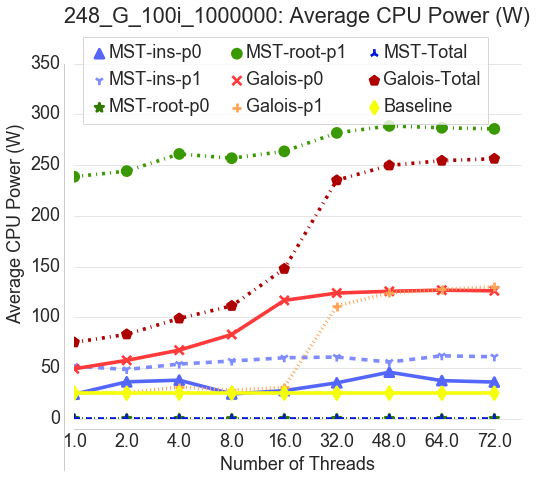

MST Power 248_G_75i_1000000
Data for plot:
      what            Network  Threads  MST-ins-p0  MST-ins-p1  MST-del-p0  \
id                                                                           
4    Power  248_G_75i_1000000        1   23.552375   53.850650   75.482275   
140  Power  248_G_75i_1000000        2   34.036475   55.569500   71.685675   
116  Power  248_G_75i_1000000        4   35.534700   54.227650   70.691375   
92   Power  248_G_75i_1000000        8   29.313950   56.594100   78.033550   
24   Power  248_G_75i_1000000       16   27.217400   58.584300  102.174200   
36   Power  248_G_75i_1000000       32   58.402125   64.456950   85.577625   
76   Power  248_G_75i_1000000       48   43.177300   64.927750   92.161200   
88   Power  248_G_75i_1000000       64   39.533275   63.271300   85.713375   
44   Power  248_G_75i_1000000       72   40.221350   63.298025   81.555500   

     MST-del-p1   MST-Total  MST-root-p0  MST-root-p1  ...     Galois-p1  \
id                    

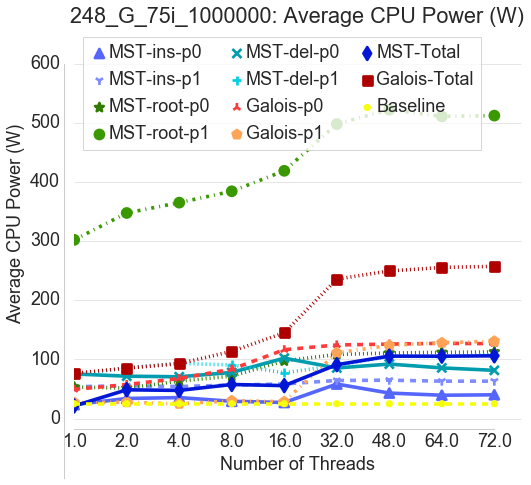

MST Power 248_ER_100i_1000000
Data for plot:
      what              Network  Threads  MST-ins-p0  MST-ins-p1  MST-del-p0  \
id                                                                             
8    Power  248_ER_100i_1000000        1   26.413725   54.416500   72.070350   
108  Power  248_ER_100i_1000000        2   49.261925   55.945100   78.517950   
124  Power  248_ER_100i_1000000        4   59.814325   59.951550   77.064775   
56   Power  248_ER_100i_1000000        8   71.429575   65.197250   78.653350   
104  Power  248_ER_100i_1000000       16   54.458850  105.013700   77.009525   
40   Power  248_ER_100i_1000000       32   75.825375  114.614700   81.848600   
64   Power  248_ER_100i_1000000       48   99.575025  110.731875   90.615850   
128  Power  248_ER_100i_1000000       64   98.020900  111.748375   83.655250   
68   Power  248_ER_100i_1000000       72  101.063175  112.285350   96.977750   

     MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...     Galois-p1  \

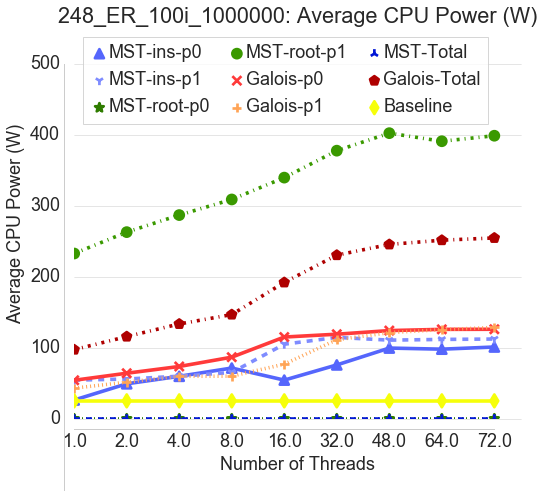

MST Power 248_ER_75i_1000000
Data for plot:
      what             Network  Threads  MST-ins-p0  MST-ins-p1  MST-del-p0  \
id                                                                            
32   Power  248_ER_75i_1000000        1   21.261325   55.167000   67.686175   
100  Power  248_ER_75i_1000000        2   48.474975   56.035700   71.033625   
20   Power  248_ER_75i_1000000        4   54.913700   61.941200   63.384150   
96   Power  248_ER_75i_1000000        8   61.612100   67.314575   78.509400   
132  Power  248_ER_75i_1000000       16   42.710575  100.811850   82.056750   
16   Power  248_ER_75i_1000000       32   81.520200   99.133950   92.006675   
136  Power  248_ER_75i_1000000       48   97.119575  100.907100   90.431800   
28   Power  248_ER_75i_1000000       64   95.776825  103.449700   94.057200   
52   Power  248_ER_75i_1000000       72   88.587250  102.895550   85.646925   

     MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...     Galois-p1  \
id         

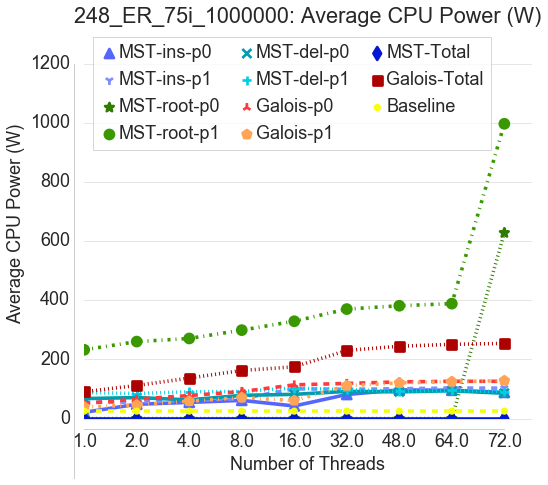

MST Energy 248_G_100i_1000000
Data for plot:
       what             Network  Threads  MST-ins-p0  MST-ins-p1  MST-del-p0  \
id                                                                             
81   Energy  248_G_100i_1000000        1   23.280425   50.139350   17.586825   
121  Energy  248_G_100i_1000000        2   34.340925   46.137975   14.919275   
85   Energy  248_G_100i_1000000        4   22.939275   32.681200    7.228500   
49   Energy  248_G_100i_1000000        8   15.097650   35.265950    5.101000   
61   Energy  248_G_100i_1000000       16   14.906825   31.954025    4.263375   
1    Energy  248_G_100i_1000000       32   17.859100   30.468275    5.782650   
73   Energy  248_G_100i_1000000       48   25.178150   30.174200    6.343525   
113  Energy  248_G_100i_1000000       64   18.978800   31.340000    6.345700   
13   Energy  248_G_100i_1000000       72   19.266900   32.546650    7.162900   

     MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...      Galois-p1  

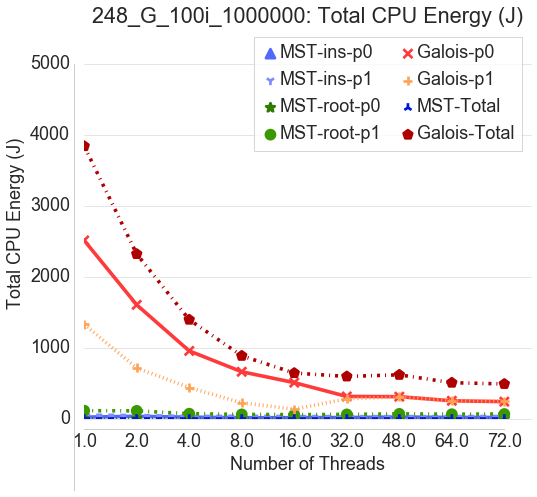

MST Energy 248_G_75i_1000000
Data for plot:
       what            Network  Threads  MST-ins-p0  MST-ins-p1  MST-del-p0  \
id                                                                            
5    Energy  248_G_75i_1000000        1   19.914350   45.858325   18.411250   
141  Energy  248_G_75i_1000000        2   27.152100   44.318850   14.398625   
117  Energy  248_G_75i_1000000        4   20.094575   30.945300    7.133425   
93   Energy  248_G_75i_1000000        8   17.404675   33.609000    5.713875   
25   Energy  248_G_75i_1000000       16   16.428275   35.361375    8.657525   
37   Energy  248_G_75i_1000000       32   27.220375   30.041525    7.751550   
77   Energy  248_G_75i_1000000       48   20.512500   30.849350    6.330550   
89   Energy  248_G_75i_1000000       64   18.216875   29.154925    7.201625   
45   Energy  248_G_75i_1000000       72   17.748300   27.937325    6.588975   

     MST-del-p1   MST-Total  MST-root-p0  MST-root-p1  ...      Galois-p1  \
id       

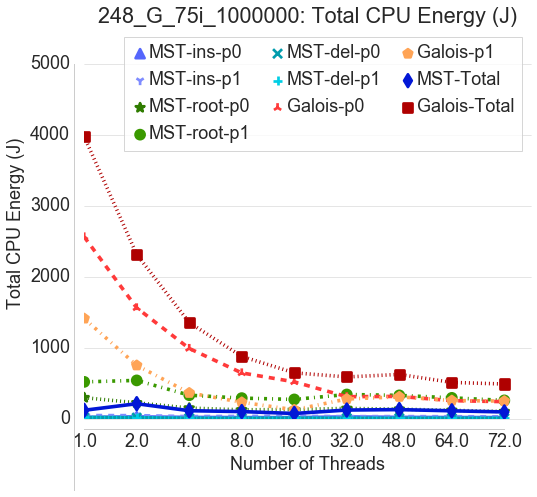

MST Energy 248_ER_100i_1000000
Data for plot:
       what              Network  Threads  MST-ins-p0  MST-ins-p1  MST-del-p0  \
id                                                                              
9    Energy  248_ER_100i_1000000        1   28.600475   59.075850   17.929050   
109  Energy  248_ER_100i_1000000        2   28.503800   32.371400   14.819650   
125  Energy  248_ER_100i_1000000        4   19.033125   19.069375    8.033775   
57   Energy  248_ER_100i_1000000        8   14.476150   13.237550    6.201025   
105  Energy  248_ER_100i_1000000       16    6.614850   12.458425    5.065600   
41   Energy  248_ER_100i_1000000       32    9.483875   13.759675    5.746075   
65   Energy  248_ER_100i_1000000       48   12.326575   13.720500    7.214225   
129  Energy  248_ER_100i_1000000       64   14.952750   17.160525    7.295325   
69   Energy  248_ER_100i_1000000       72   11.237000   12.499800    9.068775   

     MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...     

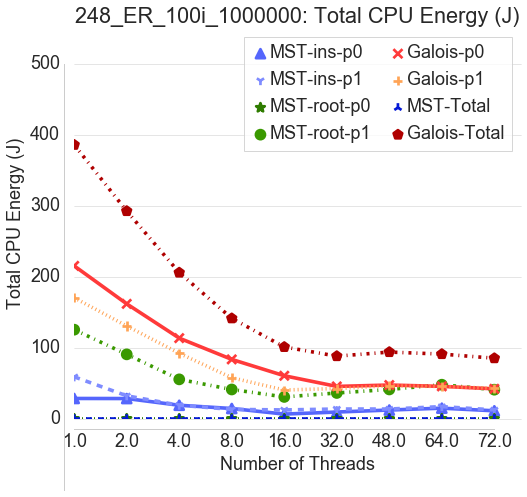

MST Energy 248_ER_75i_1000000
Data for plot:
       what             Network  Threads  MST-ins-p0  MST-ins-p1  MST-del-p0  \
id                                                                             
33   Energy  248_ER_75i_1000000        1   18.297350   47.472650   16.967900   
101  Energy  248_ER_75i_1000000        2   22.904425   26.482525   13.688175   
21   Energy  248_ER_75i_1000000        4   14.984175   16.902400    6.154100   
97   Energy  248_ER_75i_1000000        8   12.423250   13.440175    6.249425   
133  Energy  248_ER_75i_1000000       16    4.935525   11.623225    5.205250   
17   Energy  248_ER_75i_1000000       32   12.242525   14.794875    6.312625   
137  Energy  248_ER_75i_1000000       48   13.504975   14.022800    8.295250   
29   Energy  248_ER_75i_1000000       64   15.742375   17.069125    7.800525   
53   Energy  248_ER_75i_1000000       72   11.288100   13.135725    7.465975   

     MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...     Galois-p1  \

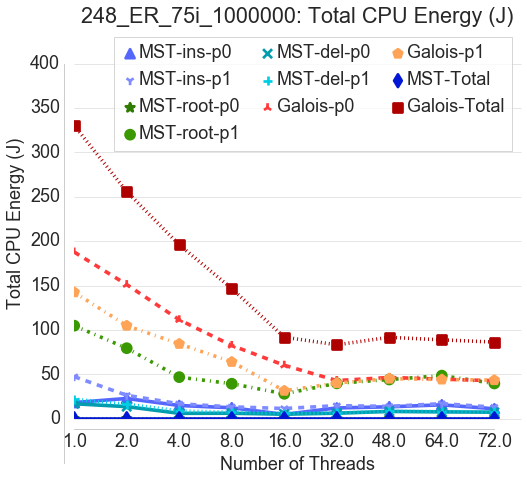

MST Memory 248_G_100i_1000000
Data for plot:
       what             Network  Threads  MST-ins-p0  MST-ins-p1  MST-del-p0  \
id                                                                             
82   Memory  248_G_100i_1000000        1           0           0           0   
122  Memory  248_G_100i_1000000        2           0           0           0   
86   Memory  248_G_100i_1000000        4           0           0           0   
50   Memory  248_G_100i_1000000        8           0           0           0   
62   Memory  248_G_100i_1000000       16           0           0           0   
2    Memory  248_G_100i_1000000       32           0           0           0   
74   Memory  248_G_100i_1000000       48           0           0           0   
114  Memory  248_G_100i_1000000       64           0           0           0   
14   Memory  248_G_100i_1000000       72           0           0           0   

     MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    Galois-p1  \


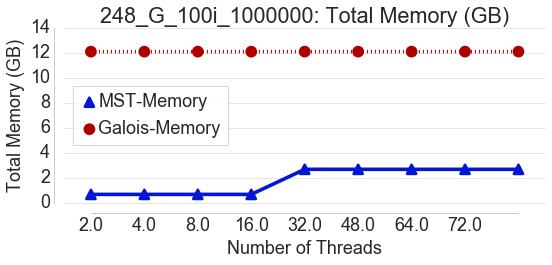

MST Memory 248_G_75i_1000000
Data for plot:
       what            Network  Threads  MST-ins-p0  MST-ins-p1  MST-del-p0  \
id                                                                            
6    Memory  248_G_75i_1000000        1           0           0           0   
142  Memory  248_G_75i_1000000        2           0           0           0   
118  Memory  248_G_75i_1000000        4           0           0           0   
94   Memory  248_G_75i_1000000        8           0           0           0   
26   Memory  248_G_75i_1000000       16           0           0           0   
38   Memory  248_G_75i_1000000       32           0           0           0   
78   Memory  248_G_75i_1000000       48           0           0           0   
90   Memory  248_G_75i_1000000       64           0           0           0   
46   Memory  248_G_75i_1000000       72           0           0           0   

     MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    Galois-p1  \
id          

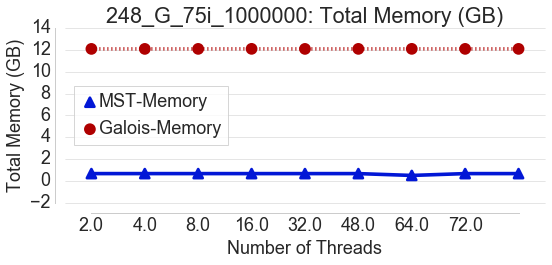

MST Memory 248_ER_100i_1000000
Data for plot:
       what              Network  Threads  MST-ins-p0  MST-ins-p1  MST-del-p0  \
id                                                                              
10   Memory  248_ER_100i_1000000        1           0           0           0   
110  Memory  248_ER_100i_1000000        2           0           0           0   
126  Memory  248_ER_100i_1000000        4           0           0           0   
58   Memory  248_ER_100i_1000000        8           0           0           0   
106  Memory  248_ER_100i_1000000       16           0           0           0   
42   Memory  248_ER_100i_1000000       32           0           0           0   
66   Memory  248_ER_100i_1000000       48           0           0           0   
130  Memory  248_ER_100i_1000000       64           0           0           0   
70   Memory  248_ER_100i_1000000       72           0           0           0   

     MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    G

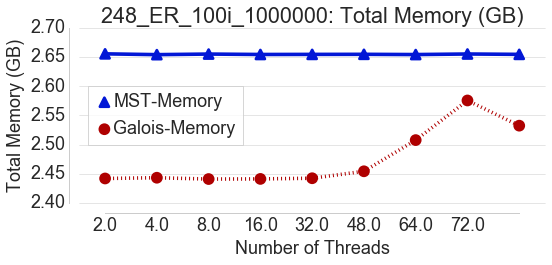

MST Memory 248_ER_75i_1000000
Data for plot:
       what             Network  Threads  MST-ins-p0  MST-ins-p1  MST-del-p0  \
id                                                                             
34   Memory  248_ER_75i_1000000        1           0           0           0   
102  Memory  248_ER_75i_1000000        2           0           0           0   
22   Memory  248_ER_75i_1000000        4           0           0           0   
98   Memory  248_ER_75i_1000000        8           0           0           0   
134  Memory  248_ER_75i_1000000       16           0           0           0   
18   Memory  248_ER_75i_1000000       32           0           0           0   
138  Memory  248_ER_75i_1000000       48           0           0           0   
30   Memory  248_ER_75i_1000000       64           0           0           0   
54   Memory  248_ER_75i_1000000       72           0           0           0   

     MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    Galois-p1  \


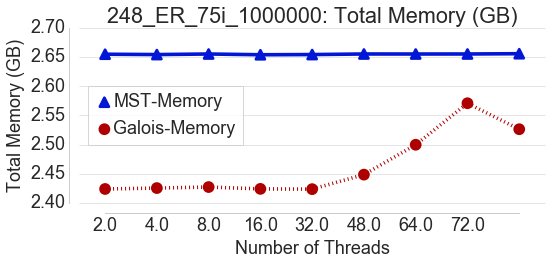

MST Time 248_G_100i_1000000
Data for plot:
     what             Network  Threads  MST-ins-p0  MST-ins-p1  MST-del-p0  \
id                                                                           
83   Time  248_G_100i_1000000        1    0.966800    0.966800    0.251975   
123  Time  248_G_100i_1000000        2    0.946950    0.946950    0.195050   
87   Time  248_G_100i_1000000        4    0.604250    0.604250    0.095125   
51   Time  248_G_100i_1000000        8    0.618925    0.618925    0.064600   
63   Time  248_G_100i_1000000       16    0.531075    0.531075    0.062400   
3    Time  248_G_100i_1000000       32    0.500025    0.500025    0.072175   
75   Time  248_G_100i_1000000       48    0.543950    0.543950    0.075125   
115  Time  248_G_100i_1000000       64    0.504125    0.504125    0.077800   
15   Time  248_G_100i_1000000       72    0.534125    0.534125    0.082850   

     MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    Galois-p1  \
id                      

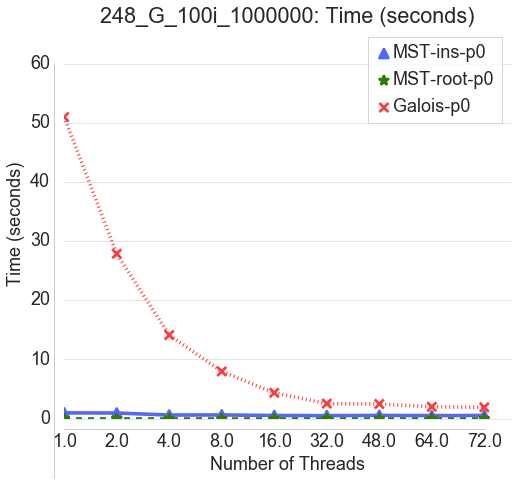

MST Time 248_G_75i_1000000
Data for plot:
     what            Network  Threads  MST-ins-p0  MST-ins-p1  MST-del-p0  \
id                                                                          
7    Time  248_G_75i_1000000        1    0.851175    0.851175    0.243950   
143  Time  248_G_75i_1000000        2    0.797675    0.797675    0.200850   
119  Time  248_G_75i_1000000        4    0.570400    0.570400    0.100925   
95   Time  248_G_75i_1000000        8    0.595000    0.595000    0.072775   
27   Time  248_G_75i_1000000       16    0.603625    0.603625    0.085000   
39   Time  248_G_75i_1000000       32    0.466050    0.466050    0.090725   
79   Time  248_G_75i_1000000       48    0.475150    0.475150    0.068750   
91   Time  248_G_75i_1000000       64    0.460750    0.460750    0.086150   
47   Time  248_G_75i_1000000       72    0.441400    0.441400    0.080975   

     MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    Galois-p1  \
id                                  

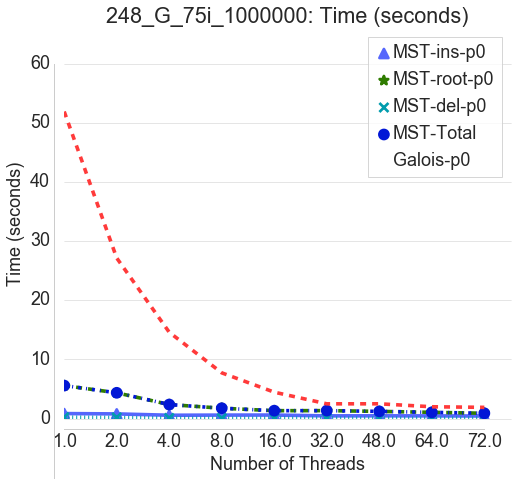

MST Time 248_ER_100i_1000000
Data for plot:
     what              Network  Threads  MST-ins-p0  MST-ins-p1  MST-del-p0  \
id                                                                            
11   Time  248_ER_100i_1000000        1    1.085525    1.085525    0.248700   
111  Time  248_ER_100i_1000000        2    0.578600    0.578600    0.189175   
127  Time  248_ER_100i_1000000        4    0.318150    0.318150    0.104200   
59   Time  248_ER_100i_1000000        8    0.202800    0.202800    0.078700   
107  Time  248_ER_100i_1000000       16    0.119650    0.119650    0.065425   
43   Time  248_ER_100i_1000000       32    0.121125    0.121125    0.069925   
67   Time  248_ER_100i_1000000       48    0.123875    0.123875    0.079625   
131  Time  248_ER_100i_1000000       64    0.153550    0.153550    0.088175   
71   Time  248_ER_100i_1000000       72    0.111325    0.111325    0.095325   

     MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    Galois-p1  \
id          

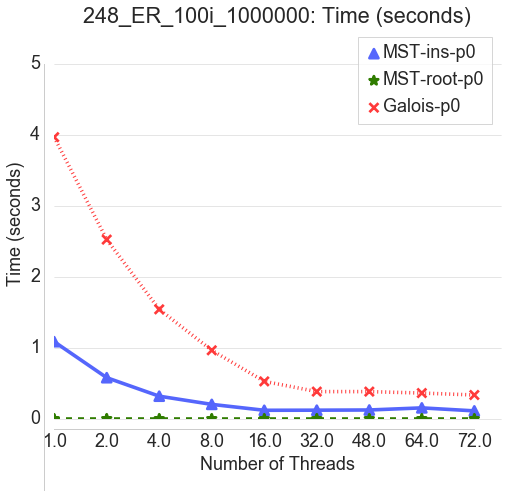

MST Time 248_ER_75i_1000000
Data for plot:
     what             Network  Threads  MST-ins-p0  MST-ins-p1  MST-del-p0  \
id                                                                           
35   Time  248_ER_75i_1000000        1    0.860600    0.860600    0.250500   
103  Time  248_ER_75i_1000000        2    0.472575    0.472575    0.193100   
23   Time  248_ER_75i_1000000        4    0.272850    0.272850    0.097950   
99   Time  248_ER_75i_1000000        8    0.200400    0.200400    0.080475   
135  Time  248_ER_75i_1000000       16    0.115425    0.115425    0.062600   
19   Time  248_ER_75i_1000000       32    0.149550    0.149550    0.068550   
139  Time  248_ER_75i_1000000       48    0.138950    0.138950    0.092150   
31   Time  248_ER_75i_1000000       64    0.164825    0.164825    0.084975   
55   Time  248_ER_75i_1000000       72    0.127650    0.127650    0.087725   

     MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    Galois-p1  \
id                      

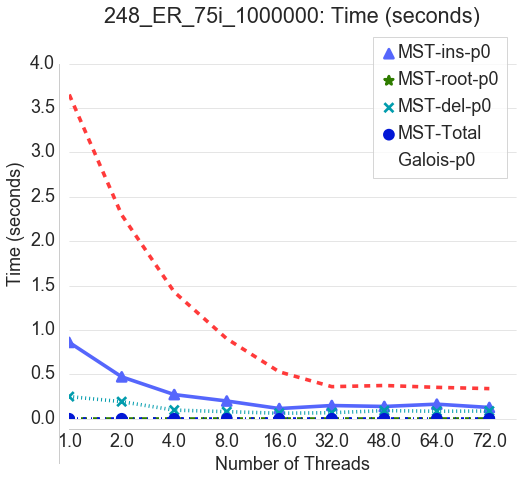

Galois memory / Update memory:
{ '248_ER_100i_1000000': 0.96995042914362695,
  '248_ER_75i_1000000': 0.96815419296242677,
  '248_G_100i_1000000': 17.978170123559195,
  '248_G_75i_1000000': 23.940170682086684}
MST Power com-lj-org-weighted_75i_1000000
Data for plot:
      what                          Network  Threads  MST-ins-p0  MST-ins-p1  \
id                                                                             
144  Power  com-lj-org-weighted_75i_1000000        1   61.293167   74.523478   
148  Power  com-lj-org-weighted_75i_1000000        2   58.770200   70.773175   
92   Power  com-lj-org-weighted_75i_1000000        4   57.741087   68.284388   
140  Power  com-lj-org-weighted_75i_1000000        8   58.524575   75.764413   
0    Power  com-lj-org-weighted_75i_1000000       16   56.319088   71.858338   
120  Power  com-lj-org-weighted_75i_1000000       32   61.546637   67.608662   
104  Power  com-lj-org-weighted_75i_1000000       48   52.055388   70.013963   
212  Power  co

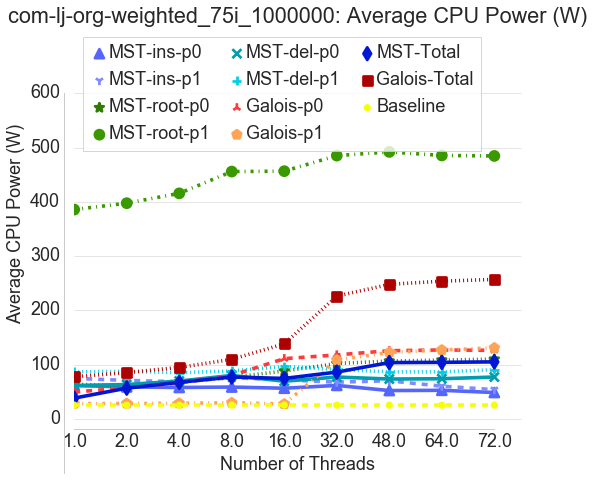

MST Power com-lj-org-weighted_100i_1000000
Data for plot:
      what                           Network  Threads  MST-ins-p0  MST-ins-p1  \
id                                                                              
20   Power  com-lj-org-weighted_100i_1000000        1   64.987513   74.775225   
132  Power  com-lj-org-weighted_100i_1000000        2   62.902988   72.790250   
76   Power  com-lj-org-weighted_100i_1000000        4   61.407150   71.684250   
108  Power  com-lj-org-weighted_100i_1000000        8   62.148575   77.246737   
128  Power  com-lj-org-weighted_100i_1000000       16   67.473137   75.676212   
192  Power  com-lj-org-weighted_100i_1000000       32   59.076737   71.324687   
96   Power  com-lj-org-weighted_100i_1000000       48   50.918188   66.435300   
172  Power  com-lj-org-weighted_100i_1000000       64   39.602137   64.756388   
4    Power  com-lj-org-weighted_100i_1000000       72   40.636400   57.640588   

     MST-del-p0  MST-del-p1  MST-Total  MST-root-p

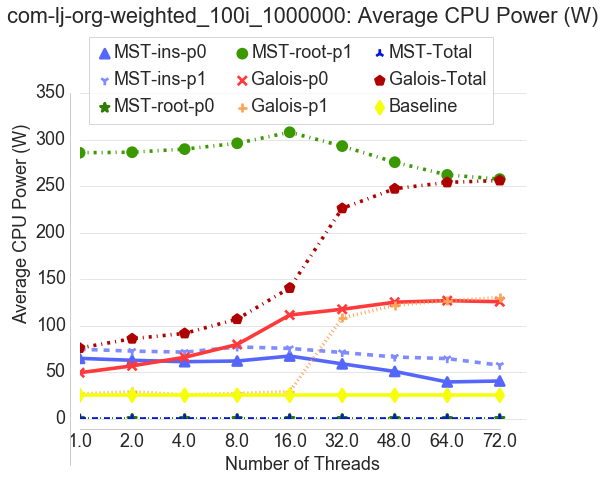

MST Power soc-pokec_100i_1000000
Data for plot:
      what                 Network  Threads  MST-ins-p0  MST-ins-p1  \
id                                                                    
16   Power  soc-pokec_100i_1000000        1   76.630750   82.331525   
88   Power  soc-pokec_100i_1000000        2   72.340725   77.907688   
196  Power  soc-pokec_100i_1000000        4   77.999163   82.175925   
8    Power  soc-pokec_100i_1000000        8   77.290800   81.299312   
68   Power  soc-pokec_100i_1000000       16   70.170500   76.797775   
32   Power  soc-pokec_100i_1000000       32   71.426513   79.997163   
36   Power  soc-pokec_100i_1000000       48   59.478250   80.868550   
200  Power  soc-pokec_100i_1000000       64   56.539700   72.758375   
168  Power  soc-pokec_100i_1000000       72   54.395725   72.659987   

     MST-del-p0  MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    \
id                                                                ...     
16    63.457638   79

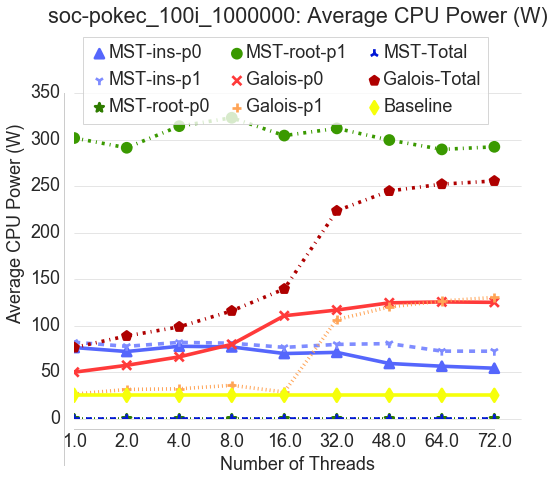

MST Power youtubeNetwork_100i_1000000
Data for plot:
      what                      Network  Threads  MST-ins-p0  MST-ins-p1  \
id                                                                         
124  Power  youtubeNetwork_100i_1000000        1   61.039925   74.074625   
12   Power  youtubeNetwork_100i_1000000        2   78.736850   82.815200   
24   Power  youtubeNetwork_100i_1000000        4   76.000875   84.298850   
160  Power  youtubeNetwork_100i_1000000        8   66.131950   76.902675   
156  Power  youtubeNetwork_100i_1000000       16   73.701100   80.669600   
72   Power  youtubeNetwork_100i_1000000       32   65.168275   76.314475   
84   Power  youtubeNetwork_100i_1000000       48   67.358450   66.037375   
116  Power  youtubeNetwork_100i_1000000       64   59.030875   78.623725   
152  Power  youtubeNetwork_100i_1000000       72   58.590275   71.922900   

     MST-del-p0  MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    \
id                                 

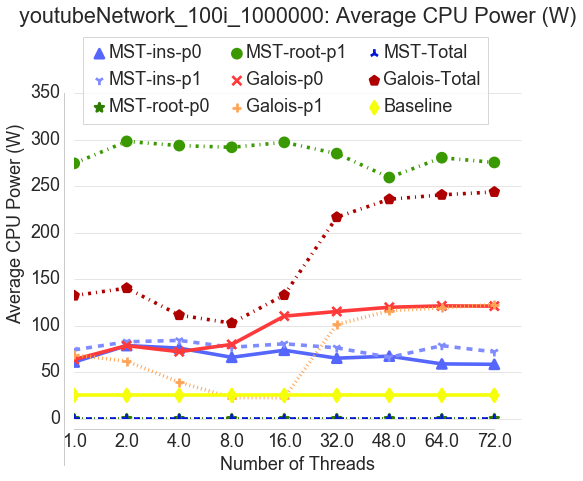

MST Power youtubeNetwork_75i_1000000
Data for plot:
      what                     Network  Threads  MST-ins-p0  MST-ins-p1  \
id                                                                        
80   Power  youtubeNetwork_75i_1000000        1   71.160650   71.133050   
180  Power  youtubeNetwork_75i_1000000        2   73.799750   75.115150   
40   Power  youtubeNetwork_75i_1000000        4   64.040400   72.360100   
48   Power  youtubeNetwork_75i_1000000        8   74.999350   79.793750   
28   Power  youtubeNetwork_75i_1000000       16   68.661450   80.215825   
112  Power  youtubeNetwork_75i_1000000       32   64.122125   81.683225   
52   Power  youtubeNetwork_75i_1000000       48   68.237000   79.411425   
208  Power  youtubeNetwork_75i_1000000       64   63.474575   71.521875   
100  Power  youtubeNetwork_75i_1000000       72   60.430775   78.137600   

     MST-del-p0  MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    \
id                                             

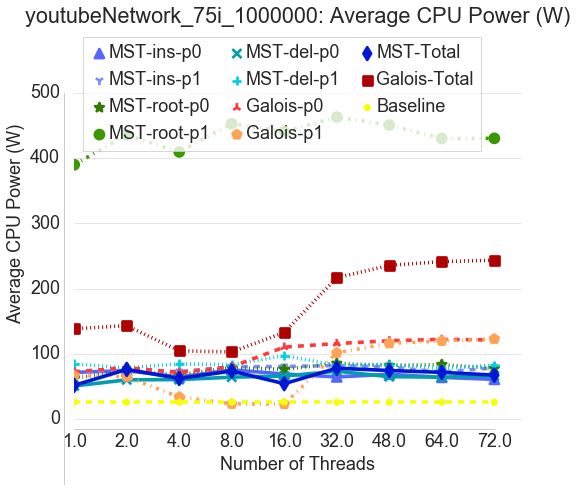

MST Power soc-pokec_75i_1000000
Data for plot:
      what                Network  Threads  MST-ins-p0  MST-ins-p1  \
id                                                                   
136  Power  soc-pokec_75i_1000000        1   62.584187   71.855238   
64   Power  soc-pokec_75i_1000000        2   78.921163   86.353487   
184  Power  soc-pokec_75i_1000000        4   76.638312   82.685850   
56   Power  soc-pokec_75i_1000000        8   76.355275   87.827450   
176  Power  soc-pokec_75i_1000000       16   78.547612   80.784662   
164  Power  soc-pokec_75i_1000000       32   74.847175   84.449950   
60   Power  soc-pokec_75i_1000000       48   65.710887   81.031775   
188  Power  soc-pokec_75i_1000000       64   55.226238   75.760625   
44   Power  soc-pokec_75i_1000000       72   62.931363   76.476888   

     MST-del-p0  MST-del-p1   MST-Total  MST-root-p0  MST-root-p1  ...    \
id                                                                 ...     
136   64.531500   75.728875   

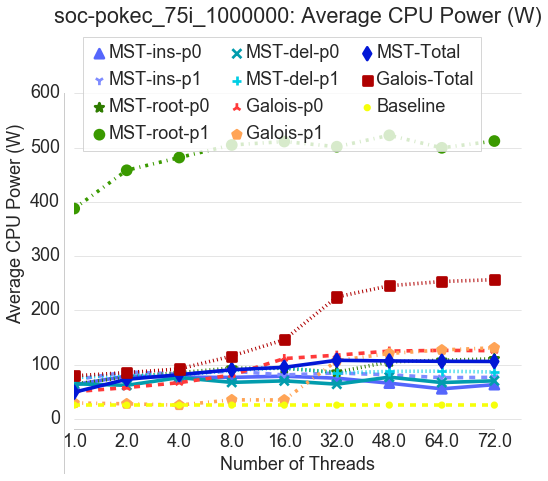

MST Energy com-lj-org-weighted_75i_1000000
Data for plot:
       what                          Network  Threads  MST-ins-p0  MST-ins-p1  \
id                                                                              
145  Energy  com-lj-org-weighted_75i_1000000        1   56.187000   68.269267   
149  Energy  com-lj-org-weighted_75i_1000000        2   48.611950   58.729450   
93   Energy  com-lj-org-weighted_75i_1000000        4   39.111850   46.300713   
141  Energy  com-lj-org-weighted_75i_1000000        8   37.524675   48.949787   
1    Energy  com-lj-org-weighted_75i_1000000       16   38.492125   48.776112   
121  Energy  com-lj-org-weighted_75i_1000000       32   37.470463   40.822950   
105  Energy  com-lj-org-weighted_75i_1000000       48   34.770250   46.093387   
213  Energy  com-lj-org-weighted_75i_1000000       64   33.693575   38.376825   
205  Energy  com-lj-org-weighted_75i_1000000       72   30.880337   32.656375   

     MST-del-p0  MST-del-p1  MST-Total  MST-root-p

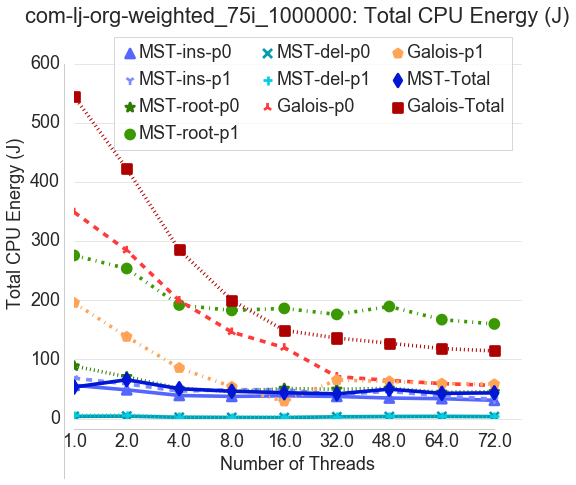

MST Energy com-lj-org-weighted_100i_1000000
Data for plot:
       what                           Network  Threads  MST-ins-p0  \
id                                                                   
21   Energy  com-lj-org-weighted_100i_1000000        1   67.878588   
133  Energy  com-lj-org-weighted_100i_1000000        2   57.201025   
77   Energy  com-lj-org-weighted_100i_1000000        4   46.109975   
109  Energy  com-lj-org-weighted_100i_1000000        8   42.060063   
129  Energy  com-lj-org-weighted_100i_1000000       16   45.334738   
193  Energy  com-lj-org-weighted_100i_1000000       32   40.268225   
97   Energy  com-lj-org-weighted_100i_1000000       48   35.243450   
173  Energy  com-lj-org-weighted_100i_1000000       64   27.184650   
5    Energy  com-lj-org-weighted_100i_1000000       72   27.603225   

     MST-ins-p1  MST-del-p0  MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  \
id                                                                             
21    78.3

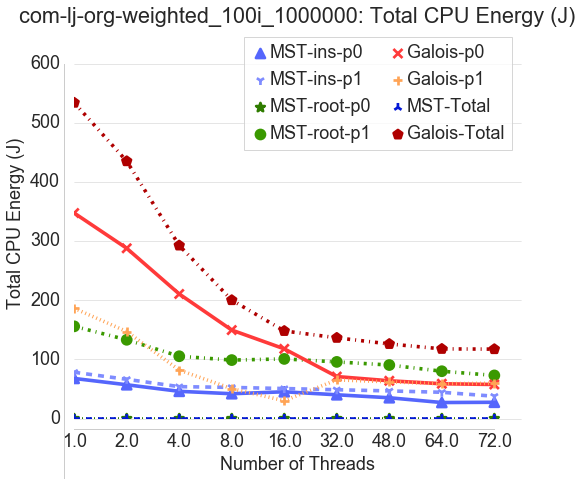

MST Energy soc-pokec_100i_1000000
Data for plot:
       what                 Network  Threads  MST-ins-p0  MST-ins-p1  \
id                                                                     
17   Energy  soc-pokec_100i_1000000        1   58.463300   62.814512   
89   Energy  soc-pokec_100i_1000000        2   47.475837   51.127950   
197  Energy  soc-pokec_100i_1000000        4   40.851700   42.993575   
9    Energy  soc-pokec_100i_1000000        8   36.360375   38.311075   
69   Energy  soc-pokec_100i_1000000       16   29.958150   32.568425   
33   Energy  soc-pokec_100i_1000000       32   36.508787   40.693850   
37   Energy  soc-pokec_100i_1000000       48   29.287800   39.957662   
201  Energy  soc-pokec_100i_1000000       64   27.221175   34.981138   
169  Energy  soc-pokec_100i_1000000       72   25.779313   34.464325   

     MST-del-p0  MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    \
id                                                                ...     
17     1

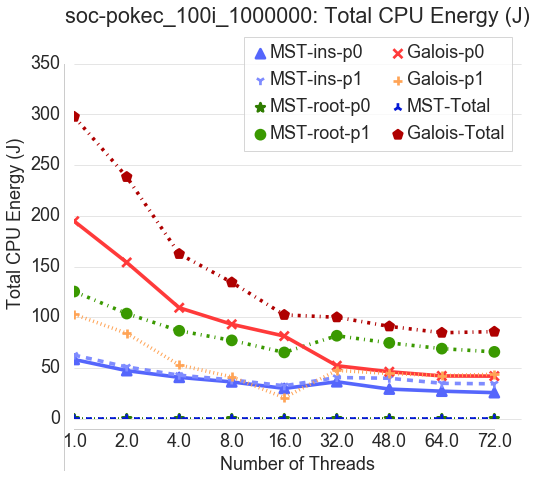

MST Energy youtubeNetwork_100i_1000000
Data for plot:
       what                      Network  Threads  MST-ins-p0  MST-ins-p1  \
id                                                                          
125  Energy  youtubeNetwork_100i_1000000        1  140.961325  171.198425   
13   Energy  youtubeNetwork_100i_1000000        2  185.134050  194.734475   
25   Energy  youtubeNetwork_100i_1000000        4  167.933400  186.253125   
161  Energy  youtubeNetwork_100i_1000000        8  144.166825  167.670225   
157  Energy  youtubeNetwork_100i_1000000       16  157.563125  172.371975   
73   Energy  youtubeNetwork_100i_1000000       32  139.309600  162.874425   
85   Energy  youtubeNetwork_100i_1000000       48  144.636075  140.885875   
117  Energy  youtubeNetwork_100i_1000000       64  124.012325  165.346450   
153  Energy  youtubeNetwork_100i_1000000       72  117.183950  143.678000   

     MST-del-p0  MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    \
id                     

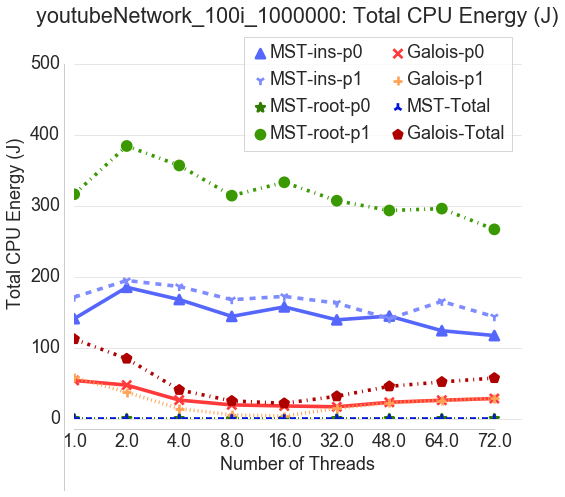

MST Energy youtubeNetwork_75i_1000000
Data for plot:
       what                     Network  Threads  MST-ins-p0  MST-ins-p1  \
id                                                                         
81   Energy  youtubeNetwork_75i_1000000        1  158.218750  155.886375   
181  Energy  youtubeNetwork_75i_1000000        2  155.778850  158.644100   
41   Energy  youtubeNetwork_75i_1000000        4  126.195850  142.527300   
49   Energy  youtubeNetwork_75i_1000000        8  149.804475  159.466275   
29   Energy  youtubeNetwork_75i_1000000       16  132.820175  154.855275   
113  Energy  youtubeNetwork_75i_1000000       32  127.762475  162.698425   
53   Energy  youtubeNetwork_75i_1000000       48  132.978300  154.682725   
209  Energy  youtubeNetwork_75i_1000000       64  115.976925  131.355600   
101  Energy  youtubeNetwork_75i_1000000       72  115.826325  149.792700   

     MST-del-p0  MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    \
id                                 

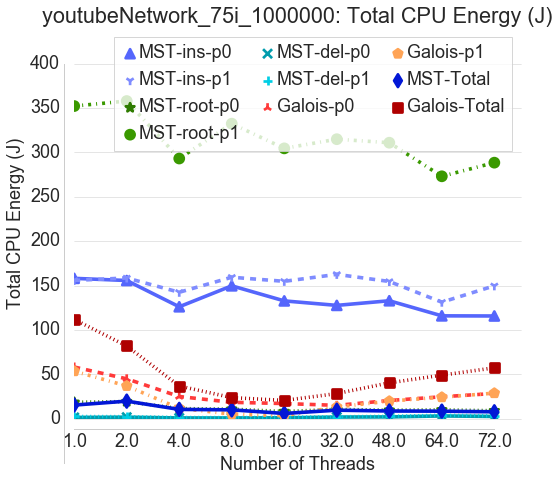

MST Energy soc-pokec_75i_1000000
Data for plot:
       what                Network  Threads  MST-ins-p0  MST-ins-p1  \
id                                                                    
137  Energy  soc-pokec_75i_1000000        1   42.710125   49.061588   
65   Energy  soc-pokec_75i_1000000        2   49.618775   54.157212   
185  Energy  soc-pokec_75i_1000000        4   39.694550   42.785100   
57   Energy  soc-pokec_75i_1000000        8   34.976975   40.161487   
177  Energy  soc-pokec_75i_1000000       16   34.405825   34.923625   
165  Energy  soc-pokec_75i_1000000       32   39.280987   44.600350   
61   Energy  soc-pokec_75i_1000000       48   32.916625   40.615225   
189  Energy  soc-pokec_75i_1000000       64   25.407713   35.144750   
45   Energy  soc-pokec_75i_1000000       72   30.664088   37.188137   

     MST-del-p0  MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    \
id                                                                ...     
137    1.859563    2

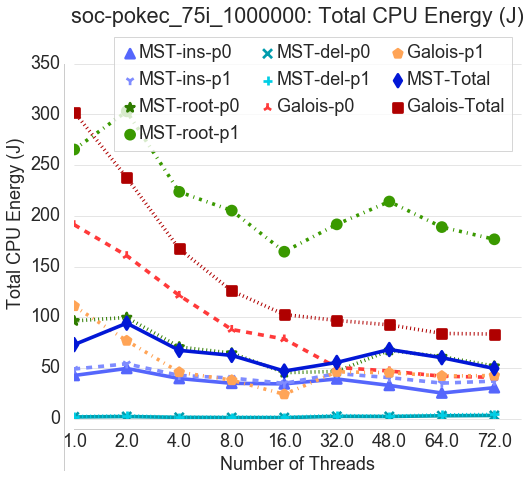

MST Memory com-lj-org-weighted_75i_1000000
Data for plot:
       what                          Network  Threads  MST-ins-p0  MST-ins-p1  \
id                                                                              
146  Memory  com-lj-org-weighted_75i_1000000        1           0           0   
150  Memory  com-lj-org-weighted_75i_1000000        2           0           0   
94   Memory  com-lj-org-weighted_75i_1000000        4           0           0   
142  Memory  com-lj-org-weighted_75i_1000000        8           0           0   
2    Memory  com-lj-org-weighted_75i_1000000       16           0           0   
122  Memory  com-lj-org-weighted_75i_1000000       32           0           0   
106  Memory  com-lj-org-weighted_75i_1000000       48           0           0   
214  Memory  com-lj-org-weighted_75i_1000000       64           0           0   
206  Memory  com-lj-org-weighted_75i_1000000       72           0           0   

     MST-del-p0  MST-del-p1  MST-Total  MST-root-p

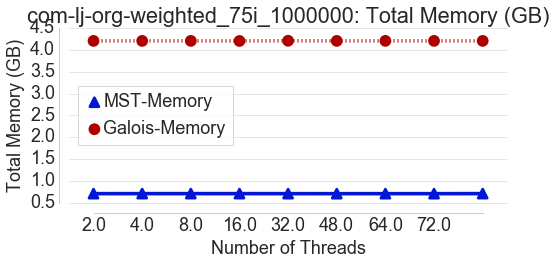

MST Memory com-lj-org-weighted_100i_1000000
Data for plot:
       what                           Network  Threads  MST-ins-p0  \
id                                                                   
22   Memory  com-lj-org-weighted_100i_1000000        1           0   
134  Memory  com-lj-org-weighted_100i_1000000        2           0   
78   Memory  com-lj-org-weighted_100i_1000000        4           0   
110  Memory  com-lj-org-weighted_100i_1000000        8           0   
130  Memory  com-lj-org-weighted_100i_1000000       16           0   
194  Memory  com-lj-org-weighted_100i_1000000       32           0   
98   Memory  com-lj-org-weighted_100i_1000000       48           0   
174  Memory  com-lj-org-weighted_100i_1000000       64           0   
6    Memory  com-lj-org-weighted_100i_1000000       72           0   

     MST-ins-p1  MST-del-p0  MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  \
id                                                                             
22        

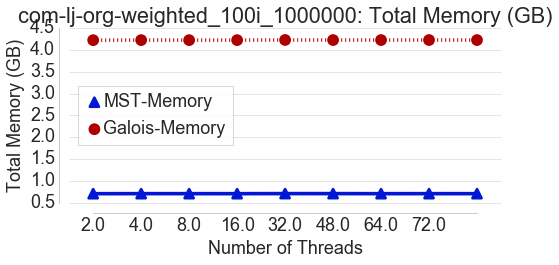

MST Memory soc-pokec_100i_1000000
Data for plot:
       what                 Network  Threads  MST-ins-p0  MST-ins-p1  \
id                                                                     
18   Memory  soc-pokec_100i_1000000        1           0           0   
90   Memory  soc-pokec_100i_1000000        2           0           0   
198  Memory  soc-pokec_100i_1000000        4           0           0   
10   Memory  soc-pokec_100i_1000000        8           0           0   
70   Memory  soc-pokec_100i_1000000       16           0           0   
34   Memory  soc-pokec_100i_1000000       32           0           0   
38   Memory  soc-pokec_100i_1000000       48           0           0   
202  Memory  soc-pokec_100i_1000000       64           0           0   
170  Memory  soc-pokec_100i_1000000       72           0           0   

     MST-del-p0  MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    \
id                                                                ...     
18      

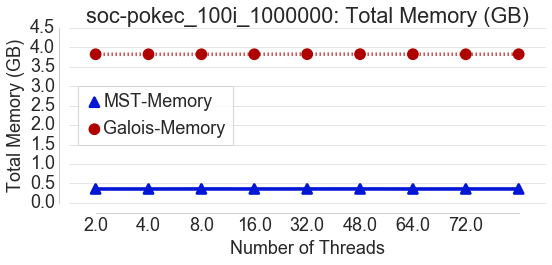

MST Memory youtubeNetwork_100i_1000000
Data for plot:
       what                      Network  Threads  MST-ins-p0  MST-ins-p1  \
id                                                                          
126  Memory  youtubeNetwork_100i_1000000        1           0           0   
14   Memory  youtubeNetwork_100i_1000000        2           0           0   
26   Memory  youtubeNetwork_100i_1000000        4           0           0   
162  Memory  youtubeNetwork_100i_1000000        8           0           0   
158  Memory  youtubeNetwork_100i_1000000       16           0           0   
74   Memory  youtubeNetwork_100i_1000000       32           0           0   
86   Memory  youtubeNetwork_100i_1000000       48           0           0   
118  Memory  youtubeNetwork_100i_1000000       64           0           0   
154  Memory  youtubeNetwork_100i_1000000       72           0           0   

     MST-del-p0  MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    \
id                     

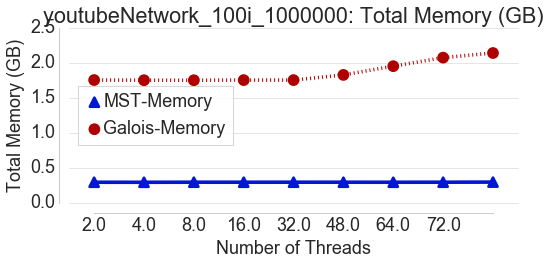

MST Memory youtubeNetwork_75i_1000000
Data for plot:
       what                     Network  Threads  MST-ins-p0  MST-ins-p1  \
id                                                                         
82   Memory  youtubeNetwork_75i_1000000        1           0           0   
182  Memory  youtubeNetwork_75i_1000000        2           0           0   
42   Memory  youtubeNetwork_75i_1000000        4           0           0   
50   Memory  youtubeNetwork_75i_1000000        8           0           0   
30   Memory  youtubeNetwork_75i_1000000       16           0           0   
114  Memory  youtubeNetwork_75i_1000000       32           0           0   
54   Memory  youtubeNetwork_75i_1000000       48           0           0   
210  Memory  youtubeNetwork_75i_1000000       64           0           0   
102  Memory  youtubeNetwork_75i_1000000       72           0           0   

     MST-del-p0  MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    \
id                                 

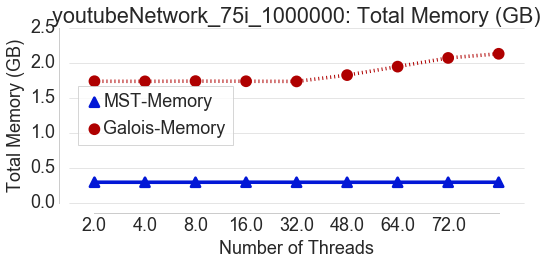

MST Memory soc-pokec_75i_1000000
Data for plot:
       what                Network  Threads  MST-ins-p0  MST-ins-p1  \
id                                                                    
138  Memory  soc-pokec_75i_1000000        1           0           0   
66   Memory  soc-pokec_75i_1000000        2           0           0   
186  Memory  soc-pokec_75i_1000000        4           0           0   
58   Memory  soc-pokec_75i_1000000        8           0           0   
178  Memory  soc-pokec_75i_1000000       16           0           0   
166  Memory  soc-pokec_75i_1000000       32           0           0   
62   Memory  soc-pokec_75i_1000000       48           0           0   
190  Memory  soc-pokec_75i_1000000       64           0           0   
46   Memory  soc-pokec_75i_1000000       72           0           0   

     MST-del-p0  MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    \
id                                                                ...     
138           0     

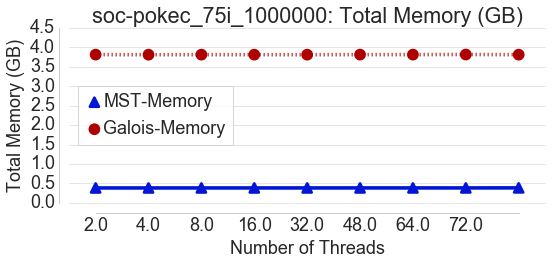

MST Time com-lj-org-weighted_75i_1000000
Data for plot:
     what                          Network  Threads  MST-ins-p0  MST-ins-p1  \
id                                                                            
147  Time  com-lj-org-weighted_75i_1000000        1    0.913422    0.913422   
151  Time  com-lj-org-weighted_75i_1000000        2    0.825262    0.825262   
95   Time  com-lj-org-weighted_75i_1000000        4    0.675475    0.675475   
143  Time  com-lj-org-weighted_75i_1000000        8    0.645112    0.645112   
3    Time  com-lj-org-weighted_75i_1000000       16    0.679100    0.679100   
123  Time  com-lj-org-weighted_75i_1000000       32    0.603538    0.603538   
107  Time  com-lj-org-weighted_75i_1000000       48    0.662963    0.662963   
215  Time  com-lj-org-weighted_75i_1000000       64    0.644613    0.644613   
207  Time  com-lj-org-weighted_75i_1000000       72    0.623875    0.623875   

     MST-del-p0  MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    \

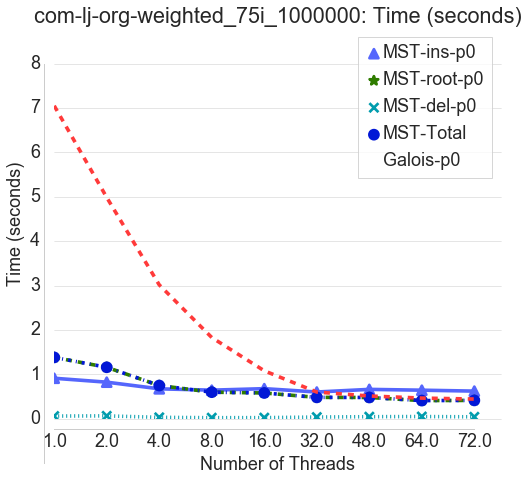

MST Time com-lj-org-weighted_100i_1000000
Data for plot:
     what                           Network  Threads  MST-ins-p0  MST-ins-p1  \
id                                                                             
23   Time  com-lj-org-weighted_100i_1000000        1    1.046300    1.046300   
135  Time  com-lj-org-weighted_100i_1000000        2    0.908587    0.908587   
79   Time  com-lj-org-weighted_100i_1000000        4    0.751700    0.751700   
111  Time  com-lj-org-weighted_100i_1000000        8    0.685113    0.685113   
131  Time  com-lj-org-weighted_100i_1000000       16    0.670413    0.670413   
195  Time  com-lj-org-weighted_100i_1000000       32    0.683325    0.683325   
99   Time  com-lj-org-weighted_100i_1000000       48    0.703563    0.703563   
175  Time  com-lj-org-weighted_100i_1000000       64    0.687025    0.687025   
7    Time  com-lj-org-weighted_100i_1000000       72    0.665312    0.665312   

     MST-del-p0  MST-del-p1  MST-Total  MST-root-p0  MST-root-

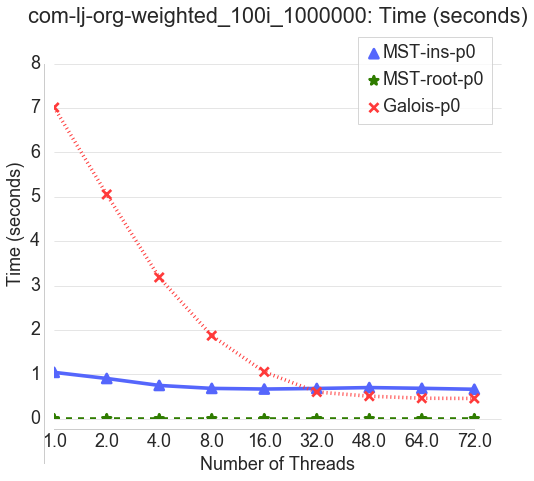

MST Time soc-pokec_100i_1000000
Data for plot:
     what                 Network  Threads  MST-ins-p0  MST-ins-p1  \
id                                                                   
19   Time  soc-pokec_100i_1000000        1    0.761988    0.761988   
91   Time  soc-pokec_100i_1000000        2    0.655675    0.655675   
199  Time  soc-pokec_100i_1000000        4    0.523450    0.523450   
11   Time  soc-pokec_100i_1000000        8    0.469963    0.469963   
71   Time  soc-pokec_100i_1000000       16    0.424362    0.424362   
35   Time  soc-pokec_100i_1000000       32    0.507537    0.507537   
39   Time  soc-pokec_100i_1000000       48    0.493362    0.493362   
203  Time  soc-pokec_100i_1000000       64    0.480550    0.480550   
171  Time  soc-pokec_100i_1000000       72    0.474050    0.474050   

     MST-del-p0  MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    \
id                                                                ...     
19     0.029125    0.029125     

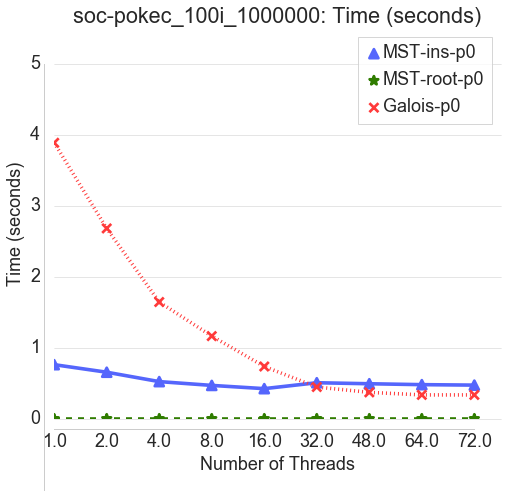

MST Time youtubeNetwork_100i_1000000
Data for plot:
     what                      Network  Threads  MST-ins-p0  MST-ins-p1  \
id                                                                        
127  Time  youtubeNetwork_100i_1000000        1    2.311000    2.311000   
15   Time  youtubeNetwork_100i_1000000        2    2.351475    2.351475   
27   Time  youtubeNetwork_100i_1000000        4    2.209225    2.209225   
163  Time  youtubeNetwork_100i_1000000        8    2.181025    2.181025   
159  Time  youtubeNetwork_100i_1000000       16    2.137425    2.137425   
75   Time  youtubeNetwork_100i_1000000       32    2.132125    2.132125   
87   Time  youtubeNetwork_100i_1000000       48    2.144475    2.144475   
119  Time  youtubeNetwork_100i_1000000       64    2.100075    2.100075   
155  Time  youtubeNetwork_100i_1000000       72    1.997450    1.997450   

     MST-del-p0  MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    \
id                                             

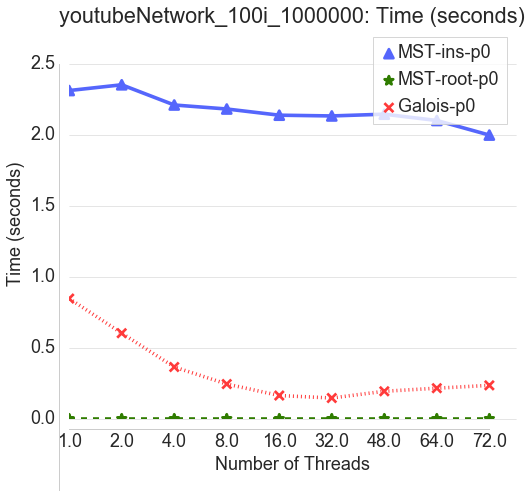

MST Time youtubeNetwork_75i_1000000
Data for plot:
     what                     Network  Threads  MST-ins-p0  MST-ins-p1  \
id                                                                       
83   Time  youtubeNetwork_75i_1000000        1    2.215750    2.215750   
183  Time  youtubeNetwork_75i_1000000        2    2.111200    2.111200   
43   Time  youtubeNetwork_75i_1000000        4    1.967575    1.967575   
51   Time  youtubeNetwork_75i_1000000        8    1.997625    1.997625   
31   Time  youtubeNetwork_75i_1000000       16    1.931300    1.931300   
115  Time  youtubeNetwork_75i_1000000       32    1.992225    1.992225   
55   Time  youtubeNetwork_75i_1000000       48    1.947725    1.947725   
211  Time  youtubeNetwork_75i_1000000       64    1.831575    1.831575   
103  Time  youtubeNetwork_75i_1000000       72    1.916225    1.916225   

     MST-del-p0  MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    \
id                                                         

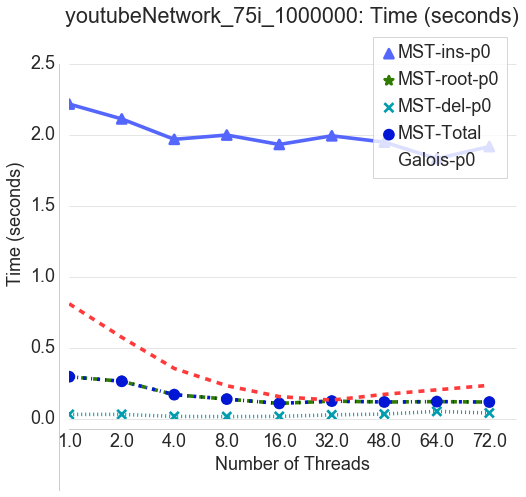

MST Time soc-pokec_75i_1000000
Data for plot:
     what                Network  Threads  MST-ins-p0  MST-ins-p1  MST-del-p0  \
id                                                                              
139  Time  soc-pokec_75i_1000000        1    0.680200    0.680200    0.028875   
67   Time  soc-pokec_75i_1000000        2    0.627312    0.627312    0.036100   
187  Time  soc-pokec_75i_1000000        4    0.517937    0.517937    0.018888   
59   Time  soc-pokec_75i_1000000        8    0.457412    0.457412    0.018150   
179  Time  soc-pokec_75i_1000000       16    0.437338    0.437338    0.016813   
167  Time  soc-pokec_75i_1000000       32    0.526300    0.526300    0.039062   
63   Time  soc-pokec_75i_1000000       48    0.501025    0.501025    0.029950   
191  Time  soc-pokec_75i_1000000       64    0.461300    0.461300    0.045237   
47   Time  soc-pokec_75i_1000000       72    0.485212    0.485212    0.049312   

     MST-del-p1  MST-Total  MST-root-p0  MST-root-p1  ...    G

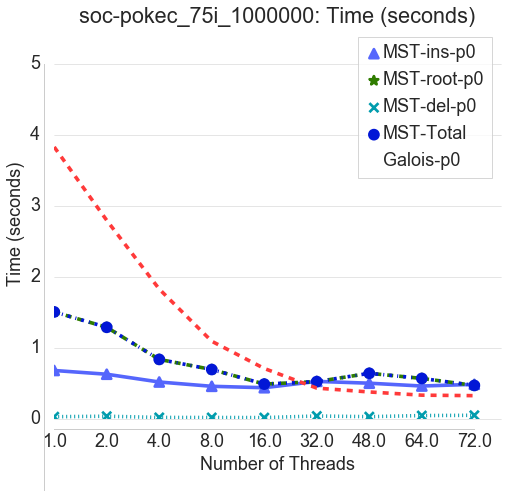

Galois memory / Update memory:
{ 'com-lj-org-weighted_100i_1000000': 5.9599104263825238,
  'com-lj-org-weighted_75i_1000000': 5.932799654586149,
  'soc-pokec_100i_1000000': 10.752048922289649,
  'soc-pokec_75i_1000000': 9.9851839468638151,
  'youtubeNetwork_100i_1000000': 7.2349223825436377,
  'youtubeNetwork_75i_1000000': 7.2415852615759331}


In [7]:
algnames = [x.split('/')[0] for x in algs]
for algfull in algs:
    alg = algfull.split('/')[0]
    processData(alg)